이번 프로젝트는 지금까지의 실습과 동일한 방법으로 CIFAR-10 데이터셋에 대해 진행해 보겠습니다. 여러분들이 만들어야 할 모델은 CIFAR-10의 10가지 클래스 중 개구리 라벨을 이상 데이터로 처리하는 모델입니다. 혹시 개구리가 출현할 경우 이를 감지하여 이상감지 경고를 발생시키는 개구리 감지 모델이라고 할 수 있겠습니다.

- 이상감지용 데이터셋 구축 (개구리 데이터를 학습데이터셋에서 제외하여 테스트 데이터셋에 포함)
- Skip-GANomaly 모델의 구현
- 모델의 학습과 검증
- 검증 결과의 시각화 (정상-이상 데이터의 anomaly score 분포 시각화, 적절한 threshold에 따른 이삼감지율 계산, 감지 성공/실패사례 시각화 포함)

In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import norm
import time
from IPython import display

print("tensorflow", tf.__version__)

tensorflow 2.2.0


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


1 Physical GPUs, 1 Logical GPUs


## 데이터 받아오기

In [3]:
cifar10 = tf.keras.datasets.cifar10

(train_data, train_labels), (test_data, test_labels) = cifar10.load_data()

train_data.shape

(50000, 32, 32, 3)

In [4]:
train_data_backup = train_data[:]

In [5]:
print("max pixel:", train_data.max())
print("min pixel:", train_data.min())

max pixel: 255
min pixel: 0


### 데이터 정규화

In [6]:
def normalization(train_data):

    normalized_train_data = (train_data - 127.5) / 127.5
    
    return normalized_train_data

In [7]:
train_data = normalization(train_data)
test_data = normalization(test_data)

print("max pixel:", train_data.max())
print("min pixel:", train_data.min())

max pixel: 1.0
min pixel: -1.0


In [8]:
train_data = train_data.reshape(train_data.shape[0], 32, 32, 3).astype('float32')
train_data.shape

(50000, 32, 32, 3)

In [9]:
test_data = test_data.reshape(test_data.shape[0], 32, 32, 3).astype('float32')
test_data.shape

(10000, 32, 32, 3)

### 데이터 시각화하여 확인하기

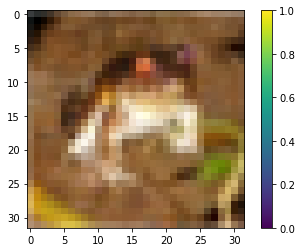

In [10]:
plt.imshow((train_data[0].reshape(32, 32, 3)+1)/2)
plt.colorbar()
plt.show()

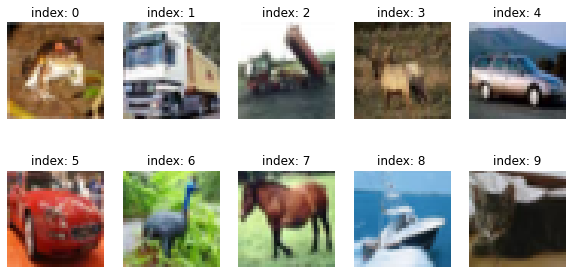

In [11]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow((train_data[i].reshape(32, 32, 3)+1)/2)
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

In [12]:
print(train_labels[0])

[6]


### 개구리 라벨을 이상치로 처리하기

In [13]:
def set_labels(labels):
    new_t_labels = []
    for old_label in labels:
        if old_label == 6:   # frog: 6
            new_t_labels.append([0])  # Frog 이상치로 처리
        else:
            new_t_labels.append([1])  # 그 외의 경우는 정상치
             
    return np.array(new_t_labels)

In [14]:
bol_train_labels = set_labels(train_labels)
bol_test_labels = set_labels(test_labels)

In [15]:
normal_data = []
normal_labels = []
anomaly_data = []
anomaly_labels = []
for data, label in zip(train_data, bol_train_labels):
    if label == 0:
        anomaly_data.append(data)
        anomaly_labels.append(label)
    else:
        normal_data.append(data)
        normal_labels.append(label)
        
normal_data = np.array(normal_data)
normal_labels = np.array(normal_labels)
anomaly_data = np.array(anomaly_data)
anomaly_labels = np.array(anomaly_labels)

In [16]:
print(normal_data.shape, normal_labels.shape)
print(anomaly_data.shape, anomaly_labels.shape)

(45000, 32, 32, 3) (45000, 1)
(5000, 32, 32, 3) (5000, 1)


In [17]:
train_data = normal_data
bol_train_labels = normal_labels
test_data = tf.concat([test_data, anomaly_data], 0)
bol_test_labels = tf.concat([bol_test_labels, anomaly_labels], 0)

In [18]:
print(train_data.shape)
print(test_data.shape)

(45000, 32, 32, 3)
(15000, 32, 32, 3)


In [19]:
print(bol_train_labels.shape)
print(bol_test_labels.shape)

(45000, 1)
(15000, 1)


In [20]:
for label in bol_train_labels:
    if label == 0:
        print(label)
print("Done")

Done


In [21]:
BUFFER_SIZE = 10000
BATCH_SIZE = 8

train_dataset = tf.data.Dataset.from_tensor_slices((train_data, bol_train_labels))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_data, bol_test_labels))
test_dataset = test_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [22]:
for data, label in train_dataset.take(1):
    print(label)

tf.Tensor(
[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]], shape=(8, 1), dtype=int64)


## 모델 구성하기

### Generator

In [23]:
class Conv_block(tf.keras.Model):
    def __init__(self, num_filters):
        super(Conv_block, self).__init__()
        self.conv_layer = tf.keras.Sequential([
            layers.Conv2D(num_filters, 3, strides=2, padding='same', use_bias=False,
                          kernel_initializer=tf.random_normal_initializer(0., 0.02)),
            layers.BatchNormalization(),
            layers.LeakyReLU(0.2),
        ])
        
    def call(self, inputs, training=False):
        outputs = self.conv_layer(inputs)
        
        return outputs

In [24]:
class Conv_T_block(tf.keras.Model):
    def __init__(self, num_filters):
        super(Conv_T_block, self).__init__()
        self.conv_T_layer = tf.keras.Sequential([
            layers.Conv2DTranspose(num_filters, 3, strides=2, padding='same', use_bias=False,
                                   kernel_initializer=tf.random_normal_initializer(0., 0.02)),
            layers.BatchNormalization(),
            layers.ReLU(),
        ])
        
    def call(self, inputs, concat, training=False):
        upsample = self.conv_T_layer(inputs)
        outputs = tf.concat([upsample, concat], -1)
        
        return outputs

In [25]:
class Generator(tf.keras.Model):
    def __init__(self, num_output_channel=3):
        super(Generator, self).__init__()
        self.encoder_1 = Conv_block(64) # 16
        self.encoder_2 = Conv_block(128) # 8
        self.encoder_3 = Conv_block(256) # 4
        self.encoder_4 = Conv_block(512) # 2
        
        self.center = Conv_block(512) # 1
        
        self.decoder_4 = Conv_T_block(512) # 2
        self.decoder_3 = Conv_T_block(256) # 4
        self.decoder_2 = Conv_T_block(128) # 8
        self.decoder_1 = Conv_T_block(64) # 16
        
        self.output_layer = layers.Conv2DTranspose(num_output_channel, 1, strides=2, padding='same', use_bias=False, # 32
                                                   kernel_initializer=tf.random_normal_initializer(0., 0.02))
                
    def call(self, inputs, training=False):
        en_1 = self.encoder_1(inputs) # gen
        en_2 = self.encoder_2(en_1)
        en_3 = self.encoder_3(en_2)
        en_4 = self.encoder_4(en_3)
        
        center = self.center(en_4)
        
        de_4 = self.decoder_4(center, en_4)
        de_3 = self.decoder_3(de_4, en_3)
        de_2 = self.decoder_2(de_3, en_2)
        de_1 = self.decoder_1(de_2, en_1)
        
        outputs = self.output_layer(de_1)
        
        return outputs

### Discriminator

In [26]:
class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.encoder_1 = Conv_block(64) # 16
        self.encoder_2 = Conv_block(128) # 8
        self.encoder_3 = Conv_block(256) # 4
        self.encoder_4 = Conv_block(512) # 2
        
        self.center = Conv_block(100) # 1
        
        self.outputs = layers.Conv2D(1, 3, strides=1, padding='same',
                                          use_bias=False, activation='sigmoid')
    
    def call(self, inputs, training=False):
        en_1 = self.encoder_1(inputs) # dis
        en_2 = self.encoder_2(en_1)
        en_3 = self.encoder_3(en_2)
        en_4 = self.encoder_4(en_3)
        
        center = self.center(en_4)
        
        outputs = self.outputs(center)
        
        return outputs, center

### 전체 모델 구성

In [27]:
generator = Generator(num_output_channel=3)  # Generator가 32X32X3 짜리 이미지를 생성해야 합니다. 
discriminator = Discriminator()

### Loss 함수

In [28]:
l2_loss = tf.keras.losses.MeanSquaredError()
l1_loss = tf.keras.losses.MeanAbsoluteError()
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

In [29]:
def discriminator_loss(pred_real, pred_fake):
    real_loss = cross_entropy(tf.ones_like(pred_real), pred_real)
    fake_loss = cross_entropy(tf.zeros_like(pred_fake), pred_fake)
    
    total_dis_loss = (real_loss + fake_loss) * 0.5
    
    return total_dis_loss

In [30]:
def generator_loss(real_output, fake_output, input_data, gen_data, latent_first, latent_sec):
    w_adv = 1.
    w_context = 40.
    w_encoder = 1.
    
    adv_loss = cross_entropy(real_output, fake_output)
    context_loss = l1_loss(input_data, gen_data)
    encoder_loss = l2_loss(latent_first, latent_sec)
    
    total_gen_loss = w_adv * adv_loss + \
                     w_context * context_loss + \
                     w_encoder * encoder_loss
    
    return total_gen_loss

In [31]:
# Optimizer 설정
generator_optimizer = tf.keras.optimizers.Adam(2e-3, 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-3, 0.5)

## Model Train

In [32]:
@tf.function()
def train_step(images):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(images, training=True)
        
        pred_real, feat_real = discriminator(images, training=True)
        pred_fake, feat_fake = discriminator(generated_images, training=True)

        gen_loss = generator_loss(pred_real, pred_fake,
                                  images, generated_images,
                                  feat_real, feat_fake)

        disc_loss = discriminator_loss(pred_real, pred_fake)        

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

In [33]:
checkpoint_path = os.path.join(os.getenv('HOME'),'aiffel/ganomaly_skip_no_norm/ckpt')

if not os.path.isdir(checkpoint_path):
    os.makedirs(checkpoint_path)
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [34]:
max_epochs = 50
steps = 0

for epoch in range(max_epochs):
    start = time.time()

    for images, labels in train_dataset:
        steps += 1
        gen_loss, disc_loss = train_step(images)
        
        if steps % 100 == 0:
            print ('Steps : {}, \t Total Gen Loss : {}, \t Total Dis Loss : {}'.format(steps, gen_loss.numpy(), disc_loss.numpy()))
        
    if (epoch + 1) % 5 == 0:
        checkpoint.save(file_prefix = checkpoint_path)
        
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))

Steps : 100, 	 Total Gen Loss : 15.525558471679688, 	 Total Dis Loss : 0.6883153915405273
Steps : 200, 	 Total Gen Loss : 19.19690704345703, 	 Total Dis Loss : 0.6553553938865662
Steps : 300, 	 Total Gen Loss : 14.556232452392578, 	 Total Dis Loss : 0.5421937704086304
Steps : 400, 	 Total Gen Loss : 15.659435272216797, 	 Total Dis Loss : 0.36897850036621094
Steps : 500, 	 Total Gen Loss : 13.881799697875977, 	 Total Dis Loss : 0.19962096214294434
Steps : 600, 	 Total Gen Loss : 17.92521095275879, 	 Total Dis Loss : 0.283000648021698
Steps : 700, 	 Total Gen Loss : 17.612777709960938, 	 Total Dis Loss : 0.2558635473251343
Steps : 800, 	 Total Gen Loss : 17.9074764251709, 	 Total Dis Loss : 0.1332038938999176
Steps : 900, 	 Total Gen Loss : 17.125673294067383, 	 Total Dis Loss : 0.07405248284339905
Steps : 1000, 	 Total Gen Loss : 16.448806762695312, 	 Total Dis Loss : 0.09978803992271423
Steps : 1100, 	 Total Gen Loss : 18.467267990112305, 	 Total Dis Loss : 0.031266797333955765
Steps :

Steps : 9000, 	 Total Gen Loss : 23.982154846191406, 	 Total Dis Loss : 0.0006542904884554446
Steps : 9100, 	 Total Gen Loss : 23.592823028564453, 	 Total Dis Loss : 0.0010842910269275308
Steps : 9200, 	 Total Gen Loss : 22.56211280822754, 	 Total Dis Loss : 0.1676875799894333
Steps : 9300, 	 Total Gen Loss : 22.050151824951172, 	 Total Dis Loss : 0.0037762350402772427
Steps : 9400, 	 Total Gen Loss : 28.154659271240234, 	 Total Dis Loss : 0.0007089936407282948
Steps : 9500, 	 Total Gen Loss : 28.27748680114746, 	 Total Dis Loss : 0.001583893783390522
Steps : 9600, 	 Total Gen Loss : 24.54677963256836, 	 Total Dis Loss : 0.0005513500655069947
Steps : 9700, 	 Total Gen Loss : 23.33477783203125, 	 Total Dis Loss : 0.00043200384243391454
Steps : 9800, 	 Total Gen Loss : 27.725688934326172, 	 Total Dis Loss : 0.0027792928740382195
Steps : 9900, 	 Total Gen Loss : 26.826791763305664, 	 Total Dis Loss : 0.0005860623205080628
Steps : 10000, 	 Total Gen Loss : 23.331329345703125, 	 Total Dis L

Steps : 17700, 	 Total Gen Loss : 29.92558479309082, 	 Total Dis Loss : 0.01049258653074503
Steps : 17800, 	 Total Gen Loss : 24.338756561279297, 	 Total Dis Loss : 0.0014922600239515305
Steps : 17900, 	 Total Gen Loss : 18.923095703125, 	 Total Dis Loss : 0.027318434789776802
Steps : 18000, 	 Total Gen Loss : 24.17660140991211, 	 Total Dis Loss : 0.0014223019825294614
Steps : 18100, 	 Total Gen Loss : 23.9598331451416, 	 Total Dis Loss : 0.0011182402959093451
Steps : 18200, 	 Total Gen Loss : 22.39436912536621, 	 Total Dis Loss : 0.0051276409067213535
Steps : 18300, 	 Total Gen Loss : 21.799457550048828, 	 Total Dis Loss : 0.008304932154715061
Steps : 18400, 	 Total Gen Loss : 21.02541732788086, 	 Total Dis Loss : 0.0036064826417714357
Steps : 18500, 	 Total Gen Loss : 22.293292999267578, 	 Total Dis Loss : 0.0015456646215170622
Steps : 18600, 	 Total Gen Loss : 21.701744079589844, 	 Total Dis Loss : 0.0013315487885847688
Steps : 18700, 	 Total Gen Loss : 21.803848266601562, 	 Total D

Steps : 26400, 	 Total Gen Loss : 24.21955108642578, 	 Total Dis Loss : 0.0006037604180164635
Steps : 26500, 	 Total Gen Loss : 24.7957706451416, 	 Total Dis Loss : 0.0006024367175996304
Steps : 26600, 	 Total Gen Loss : 23.6038875579834, 	 Total Dis Loss : 0.0009787131566554308
Steps : 26700, 	 Total Gen Loss : 24.79753875732422, 	 Total Dis Loss : 0.0003452589735388756
Steps : 26800, 	 Total Gen Loss : 24.062835693359375, 	 Total Dis Loss : 0.00022695292136631906
Steps : 26900, 	 Total Gen Loss : 21.910572052001953, 	 Total Dis Loss : 0.0009151857811957598
Steps : 27000, 	 Total Gen Loss : 22.81311798095703, 	 Total Dis Loss : 0.0002807255950756371
Steps : 27100, 	 Total Gen Loss : 23.758159637451172, 	 Total Dis Loss : 0.0025926795788109303
Steps : 27200, 	 Total Gen Loss : 23.418914794921875, 	 Total Dis Loss : 0.0008764040539972484
Steps : 27300, 	 Total Gen Loss : 22.468143463134766, 	 Total Dis Loss : 0.012409024871885777
Steps : 27400, 	 Total Gen Loss : 25.08653450012207, 	 To

Steps : 35000, 	 Total Gen Loss : 22.021760940551758, 	 Total Dis Loss : 0.0011512526543810964
Steps : 35100, 	 Total Gen Loss : 23.7304630279541, 	 Total Dis Loss : 0.0007336577400565147
Steps : 35200, 	 Total Gen Loss : 25.92569351196289, 	 Total Dis Loss : 0.0012968407245352864
Steps : 35300, 	 Total Gen Loss : 21.87417984008789, 	 Total Dis Loss : 0.0010203226702287793
Steps : 35400, 	 Total Gen Loss : 27.10287094116211, 	 Total Dis Loss : 0.002849413314834237
Steps : 35500, 	 Total Gen Loss : 23.945674896240234, 	 Total Dis Loss : 0.001865267870016396
Steps : 35600, 	 Total Gen Loss : 26.043394088745117, 	 Total Dis Loss : 0.0010851356200873852
Steps : 35700, 	 Total Gen Loss : 23.342561721801758, 	 Total Dis Loss : 0.003360106609761715
Steps : 35800, 	 Total Gen Loss : 22.766040802001953, 	 Total Dis Loss : 0.0019478766480460763
Steps : 35900, 	 Total Gen Loss : 24.272991180419922, 	 Total Dis Loss : 0.0004889557021670043
Steps : 36000, 	 Total Gen Loss : 22.791820526123047, 	 To

Steps : 43700, 	 Total Gen Loss : 25.849441528320312, 	 Total Dis Loss : 0.002382514998316765
Steps : 43800, 	 Total Gen Loss : 26.787105560302734, 	 Total Dis Loss : 0.0004666591703426093
Steps : 43900, 	 Total Gen Loss : 24.186006546020508, 	 Total Dis Loss : 0.000394828908611089
Steps : 44000, 	 Total Gen Loss : 23.434871673583984, 	 Total Dis Loss : 0.01095381285995245
Steps : 44100, 	 Total Gen Loss : 29.92234992980957, 	 Total Dis Loss : 0.00017040030797943473
Steps : 44200, 	 Total Gen Loss : 29.480844497680664, 	 Total Dis Loss : 0.000131036460516043
Steps : 44300, 	 Total Gen Loss : 27.908674240112305, 	 Total Dis Loss : 0.00015661350334994495
Steps : 44400, 	 Total Gen Loss : 32.149234771728516, 	 Total Dis Loss : 0.00017344624211546034
Steps : 44500, 	 Total Gen Loss : 24.867565155029297, 	 Total Dis Loss : 6.135614967206493e-05
Steps : 44600, 	 Total Gen Loss : 25.961212158203125, 	 Total Dis Loss : 0.00015670435095671564
Steps : 44700, 	 Total Gen Loss : 33.128509521484375

Steps : 52300, 	 Total Gen Loss : 28.38894271850586, 	 Total Dis Loss : 5.907741069677286e-05
Steps : 52400, 	 Total Gen Loss : 26.712905883789062, 	 Total Dis Loss : 0.00036753452150151134
Steps : 52500, 	 Total Gen Loss : 24.880298614501953, 	 Total Dis Loss : 9.59582903306e-05
Steps : 52600, 	 Total Gen Loss : 28.496009826660156, 	 Total Dis Loss : 8.356283797184005e-05
Steps : 52700, 	 Total Gen Loss : 25.323957443237305, 	 Total Dis Loss : 0.00011121245916001499
Steps : 52800, 	 Total Gen Loss : 26.276893615722656, 	 Total Dis Loss : 0.00013609770394396037
Steps : 52900, 	 Total Gen Loss : 25.80139923095703, 	 Total Dis Loss : 8.500365220243111e-05
Steps : 53000, 	 Total Gen Loss : 24.0645751953125, 	 Total Dis Loss : 0.0010404204949736595
Steps : 53100, 	 Total Gen Loss : 26.775012969970703, 	 Total Dis Loss : 0.0004408344393596053
Steps : 53200, 	 Total Gen Loss : 24.648792266845703, 	 Total Dis Loss : 0.00025708251632750034
Steps : 53300, 	 Total Gen Loss : 25.704042434692383, 

Steps : 61000, 	 Total Gen Loss : 24.361412048339844, 	 Total Dis Loss : 0.0024877318646758795
Steps : 61100, 	 Total Gen Loss : 22.71142578125, 	 Total Dis Loss : 0.0010215741349384189
Steps : 61200, 	 Total Gen Loss : 24.894041061401367, 	 Total Dis Loss : 0.00027173690614290535
Steps : 61300, 	 Total Gen Loss : 22.462705612182617, 	 Total Dis Loss : 0.0013693494256585836
Steps : 61400, 	 Total Gen Loss : 26.5556640625, 	 Total Dis Loss : 6.738409865647554e-05
Steps : 61500, 	 Total Gen Loss : 24.696069717407227, 	 Total Dis Loss : 2.749762097664643e-05
Steps : 61600, 	 Total Gen Loss : 28.756980895996094, 	 Total Dis Loss : 1.0781891432998236e-05
Steps : 61700, 	 Total Gen Loss : 24.416568756103516, 	 Total Dis Loss : 0.00021965143969282508
Steps : 61800, 	 Total Gen Loss : 24.177824020385742, 	 Total Dis Loss : 0.0004184748395346105
Time for epoch 11 is 77.6122772693634 sec
Steps : 61900, 	 Total Gen Loss : 26.38888168334961, 	 Total Dis Loss : 0.00013620562094729394
Steps : 62000,

Steps : 69600, 	 Total Gen Loss : 31.36318588256836, 	 Total Dis Loss : 9.162066271528602e-05
Steps : 69700, 	 Total Gen Loss : 31.66241455078125, 	 Total Dis Loss : 0.0001297804992645979
Steps : 69800, 	 Total Gen Loss : 32.1538200378418, 	 Total Dis Loss : 7.470822311006486e-05
Steps : 69900, 	 Total Gen Loss : 31.45334243774414, 	 Total Dis Loss : 0.00012211508874315768
Steps : 70000, 	 Total Gen Loss : 27.63759994506836, 	 Total Dis Loss : 0.0008824485703371465
Steps : 70100, 	 Total Gen Loss : 30.526018142700195, 	 Total Dis Loss : 0.0004812926927115768
Steps : 70200, 	 Total Gen Loss : 31.821847915649414, 	 Total Dis Loss : 5.8105102652916685e-05
Steps : 70300, 	 Total Gen Loss : 30.877267837524414, 	 Total Dis Loss : 7.655657827854156e-05
Steps : 70400, 	 Total Gen Loss : 26.36017417907715, 	 Total Dis Loss : 0.0007570842863060534
Steps : 70500, 	 Total Gen Loss : 27.15565299987793, 	 Total Dis Loss : 0.0005022487603127956
Steps : 70600, 	 Total Gen Loss : 23.835397720336914, 	 

Steps : 78300, 	 Total Gen Loss : 23.440067291259766, 	 Total Dis Loss : 0.0008594687096774578
Steps : 78400, 	 Total Gen Loss : 24.661922454833984, 	 Total Dis Loss : 0.002954881638288498
Steps : 78500, 	 Total Gen Loss : 25.161151885986328, 	 Total Dis Loss : 0.0005398355424404144
Steps : 78600, 	 Total Gen Loss : 26.536434173583984, 	 Total Dis Loss : 0.0001991312310565263
Steps : 78700, 	 Total Gen Loss : 23.520225524902344, 	 Total Dis Loss : 0.00030617869924753904
Time for epoch 14 is 78.4686975479126 sec
Steps : 78800, 	 Total Gen Loss : 26.62391471862793, 	 Total Dis Loss : 0.00029826757963746786
Steps : 78900, 	 Total Gen Loss : 26.36783218383789, 	 Total Dis Loss : 0.00031694574863649905
Steps : 79000, 	 Total Gen Loss : 24.367216110229492, 	 Total Dis Loss : 0.000313209107844159
Steps : 79100, 	 Total Gen Loss : 25.141874313354492, 	 Total Dis Loss : 0.0003260136872995645
Steps : 79200, 	 Total Gen Loss : 26.19994354248047, 	 Total Dis Loss : 0.0007218787795864046
Steps : 79

Steps : 86900, 	 Total Gen Loss : 24.498798370361328, 	 Total Dis Loss : 0.00010081489745061845
Steps : 87000, 	 Total Gen Loss : 28.953510284423828, 	 Total Dis Loss : 5.37983542017173e-05
Steps : 87100, 	 Total Gen Loss : 27.12322425842285, 	 Total Dis Loss : 5.877159128431231e-05
Steps : 87200, 	 Total Gen Loss : 23.605804443359375, 	 Total Dis Loss : 7.001868652878329e-05
Steps : 87300, 	 Total Gen Loss : 27.12704849243164, 	 Total Dis Loss : 3.682522947201505e-05
Steps : 87400, 	 Total Gen Loss : 23.519561767578125, 	 Total Dis Loss : 5.968709956505336e-05
Steps : 87500, 	 Total Gen Loss : 26.361562728881836, 	 Total Dis Loss : 7.67618403187953e-05
Steps : 87600, 	 Total Gen Loss : 25.896785736083984, 	 Total Dis Loss : 7.157542131608352e-05
Steps : 87700, 	 Total Gen Loss : 26.786659240722656, 	 Total Dis Loss : 3.0196562875062227e-05
Steps : 87800, 	 Total Gen Loss : 25.26934242248535, 	 Total Dis Loss : 3.563866994227283e-05
Steps : 87900, 	 Total Gen Loss : 29.312822341918945,

Steps : 95500, 	 Total Gen Loss : 21.964534759521484, 	 Total Dis Loss : 0.00027523154858499765
Steps : 95600, 	 Total Gen Loss : 26.752155303955078, 	 Total Dis Loss : 0.00031238459632731974
Time for epoch 17 is 75.83030271530151 sec
Steps : 95700, 	 Total Gen Loss : 26.46480941772461, 	 Total Dis Loss : 0.00010874750296352431
Steps : 95800, 	 Total Gen Loss : 24.604021072387695, 	 Total Dis Loss : 0.0003061772440560162
Steps : 95900, 	 Total Gen Loss : 23.612581253051758, 	 Total Dis Loss : 0.00035060953814536333
Steps : 96000, 	 Total Gen Loss : 24.672279357910156, 	 Total Dis Loss : 0.00010309230128768831
Steps : 96100, 	 Total Gen Loss : 25.366622924804688, 	 Total Dis Loss : 0.0001776084245648235
Steps : 96200, 	 Total Gen Loss : 25.21342658996582, 	 Total Dis Loss : 0.00010397320875199512
Steps : 96300, 	 Total Gen Loss : 25.126502990722656, 	 Total Dis Loss : 8.614541729912162e-05
Steps : 96400, 	 Total Gen Loss : 26.108253479003906, 	 Total Dis Loss : 3.161979475407861e-05
Ste

Steps : 104100, 	 Total Gen Loss : 27.699710845947266, 	 Total Dis Loss : 9.600708290236071e-05
Steps : 104200, 	 Total Gen Loss : 26.107105255126953, 	 Total Dis Loss : 5.663034608005546e-05
Steps : 104300, 	 Total Gen Loss : 27.616878509521484, 	 Total Dis Loss : 3.822216604021378e-05
Steps : 104400, 	 Total Gen Loss : 27.347991943359375, 	 Total Dis Loss : 2.256574407510925e-05
Steps : 104500, 	 Total Gen Loss : 25.78097152709961, 	 Total Dis Loss : 0.00011789999553002417
Steps : 104600, 	 Total Gen Loss : 24.45915985107422, 	 Total Dis Loss : 5.56332161067985e-05
Steps : 104700, 	 Total Gen Loss : 28.57312774658203, 	 Total Dis Loss : 7.160981476772577e-05
Steps : 104800, 	 Total Gen Loss : 25.868167877197266, 	 Total Dis Loss : 5.6415836297674105e-05
Steps : 104900, 	 Total Gen Loss : 27.693065643310547, 	 Total Dis Loss : 3.600942363846116e-05
Steps : 105000, 	 Total Gen Loss : 28.023271560668945, 	 Total Dis Loss : 1.0769704203994479e-05
Steps : 105100, 	 Total Gen Loss : 33.113

Steps : 112600, 	 Total Gen Loss : 24.947324752807617, 	 Total Dis Loss : 0.00012029088975396007
Steps : 112700, 	 Total Gen Loss : 30.08465576171875, 	 Total Dis Loss : 4.454633381101303e-05
Steps : 112800, 	 Total Gen Loss : 27.834651947021484, 	 Total Dis Loss : 8.828238787828013e-05
Steps : 112900, 	 Total Gen Loss : 27.2927188873291, 	 Total Dis Loss : 3.4944871003972366e-05
Steps : 113000, 	 Total Gen Loss : 26.66472625732422, 	 Total Dis Loss : 0.0002457398804835975
Steps : 113100, 	 Total Gen Loss : 23.64754295349121, 	 Total Dis Loss : 0.000133609923068434
Steps : 113200, 	 Total Gen Loss : 28.773208618164062, 	 Total Dis Loss : 4.571698809741065e-05
Steps : 113300, 	 Total Gen Loss : 26.99114227294922, 	 Total Dis Loss : 6.192435103002936e-05
Steps : 113400, 	 Total Gen Loss : 25.89117431640625, 	 Total Dis Loss : 4.9790291086537763e-05
Steps : 113500, 	 Total Gen Loss : 26.312238693237305, 	 Total Dis Loss : 5.513928772415966e-05
Steps : 113600, 	 Total Gen Loss : 26.9801235

Steps : 121200, 	 Total Gen Loss : 27.75277328491211, 	 Total Dis Loss : 0.03928148373961449
Steps : 121300, 	 Total Gen Loss : 32.20146942138672, 	 Total Dis Loss : 0.0005575930117629468
Steps : 121400, 	 Total Gen Loss : 34.01935577392578, 	 Total Dis Loss : 3.104167990386486e-05
Steps : 121500, 	 Total Gen Loss : 32.323394775390625, 	 Total Dis Loss : 0.00015994359273463488
Steps : 121600, 	 Total Gen Loss : 29.695587158203125, 	 Total Dis Loss : 0.0004865943919867277
Steps : 121700, 	 Total Gen Loss : 30.550689697265625, 	 Total Dis Loss : 0.00014853064203634858
Steps : 121800, 	 Total Gen Loss : 33.447296142578125, 	 Total Dis Loss : 0.0001268633350264281
Steps : 121900, 	 Total Gen Loss : 32.943443298339844, 	 Total Dis Loss : 0.00015783261915203184
Steps : 122000, 	 Total Gen Loss : 30.753129959106445, 	 Total Dis Loss : 0.006871331017464399
Steps : 122100, 	 Total Gen Loss : 28.55569076538086, 	 Total Dis Loss : 0.0002452322223689407
Steps : 122200, 	 Total Gen Loss : 30.151899

Steps : 129700, 	 Total Gen Loss : 29.52355194091797, 	 Total Dis Loss : 0.0007136440835893154
Steps : 129800, 	 Total Gen Loss : 32.18408966064453, 	 Total Dis Loss : 6.721117824781686e-05
Steps : 129900, 	 Total Gen Loss : 30.74532699584961, 	 Total Dis Loss : 3.367270983289927e-05
Steps : 130000, 	 Total Gen Loss : 34.31655502319336, 	 Total Dis Loss : 4.427533713169396e-05
Steps : 130100, 	 Total Gen Loss : 30.14887237548828, 	 Total Dis Loss : 7.523340173065662e-05
Steps : 130200, 	 Total Gen Loss : 32.806671142578125, 	 Total Dis Loss : 4.010702468804084e-05
Steps : 130300, 	 Total Gen Loss : 33.68292999267578, 	 Total Dis Loss : 6.0144910094095394e-05
Steps : 130400, 	 Total Gen Loss : 31.64557456970215, 	 Total Dis Loss : 6.705182750010863e-05
Steps : 130500, 	 Total Gen Loss : 28.66946029663086, 	 Total Dis Loss : 0.0001512819726485759
Steps : 130600, 	 Total Gen Loss : 27.277103424072266, 	 Total Dis Loss : 0.0054174247197806835
Steps : 130700, 	 Total Gen Loss : 32.331623077

Steps : 138300, 	 Total Gen Loss : 31.51563835144043, 	 Total Dis Loss : 3.639006899902597e-05
Steps : 138400, 	 Total Gen Loss : 30.451236724853516, 	 Total Dis Loss : 0.0001586871949257329
Steps : 138500, 	 Total Gen Loss : 31.15945053100586, 	 Total Dis Loss : 0.0007723499438725412
Steps : 138600, 	 Total Gen Loss : 35.4501953125, 	 Total Dis Loss : 6.385391316143796e-05
Steps : 138700, 	 Total Gen Loss : 41.971778869628906, 	 Total Dis Loss : 0.0007629517931491137
Steps : 138800, 	 Total Gen Loss : 34.03407287597656, 	 Total Dis Loss : 0.0001823774364311248
Steps : 138900, 	 Total Gen Loss : 27.78304672241211, 	 Total Dis Loss : 7.456725143129006e-05
Steps : 139000, 	 Total Gen Loss : 27.01667022705078, 	 Total Dis Loss : 0.0059233722276985645
Steps : 139100, 	 Total Gen Loss : 35.31381607055664, 	 Total Dis Loss : 6.172155553940684e-05
Steps : 139200, 	 Total Gen Loss : 32.66620635986328, 	 Total Dis Loss : 0.0004963437677361071
Steps : 139300, 	 Total Gen Loss : 32.03589248657226

Steps : 146800, 	 Total Gen Loss : 28.97926902770996, 	 Total Dis Loss : 8.02168287918903e-05
Steps : 146900, 	 Total Gen Loss : 26.236896514892578, 	 Total Dis Loss : 8.652210817672312e-05
Steps : 147000, 	 Total Gen Loss : 30.317237854003906, 	 Total Dis Loss : 6.943523476365954e-05
Steps : 147100, 	 Total Gen Loss : 28.322742462158203, 	 Total Dis Loss : 0.0001463009393773973
Steps : 147200, 	 Total Gen Loss : 28.169353485107422, 	 Total Dis Loss : 0.00012916812556795776
Steps : 147300, 	 Total Gen Loss : 25.999523162841797, 	 Total Dis Loss : 8.729847468202934e-05
Steps : 147400, 	 Total Gen Loss : 28.418907165527344, 	 Total Dis Loss : 4.344258559285663e-05
Steps : 147500, 	 Total Gen Loss : 27.58492660522461, 	 Total Dis Loss : 0.00017376757750753313
Steps : 147600, 	 Total Gen Loss : 28.28854751586914, 	 Total Dis Loss : 9.374768706038594e-05
Steps : 147700, 	 Total Gen Loss : 28.48363494873047, 	 Total Dis Loss : 6.734527414664626e-05
Steps : 147800, 	 Total Gen Loss : 25.58478

Steps : 155300, 	 Total Gen Loss : 27.708280563354492, 	 Total Dis Loss : 7.173552876338363e-05
Steps : 155400, 	 Total Gen Loss : 27.333866119384766, 	 Total Dis Loss : 3.0610299290856346e-05
Steps : 155500, 	 Total Gen Loss : 30.036640167236328, 	 Total Dis Loss : 2.846400639100466e-05
Steps : 155600, 	 Total Gen Loss : 27.730457305908203, 	 Total Dis Loss : 0.00016169450827874243
Steps : 155700, 	 Total Gen Loss : 26.776124954223633, 	 Total Dis Loss : 0.00010349266813136637
Steps : 155800, 	 Total Gen Loss : 27.08024024963379, 	 Total Dis Loss : 7.79017063905485e-05
Steps : 155900, 	 Total Gen Loss : 31.82501983642578, 	 Total Dis Loss : 7.1919598667591345e-06
Steps : 156000, 	 Total Gen Loss : 29.0744571685791, 	 Total Dis Loss : 3.561652920325287e-05
Steps : 156100, 	 Total Gen Loss : 25.38955307006836, 	 Total Dis Loss : 7.19714371371083e-05
Steps : 156200, 	 Total Gen Loss : 26.76422119140625, 	 Total Dis Loss : 5.2358813263708726e-05
Steps : 156300, 	 Total Gen Loss : 26.10759

Steps : 163800, 	 Total Gen Loss : 33.5372314453125, 	 Total Dis Loss : 0.00016347634664271027
Steps : 163900, 	 Total Gen Loss : 34.412925720214844, 	 Total Dis Loss : 1.7725647921906784e-05
Steps : 164000, 	 Total Gen Loss : 34.251380920410156, 	 Total Dis Loss : 4.9591908464208245e-06
Steps : 164100, 	 Total Gen Loss : 31.917438507080078, 	 Total Dis Loss : 7.366794307017699e-05
Steps : 164200, 	 Total Gen Loss : 30.439788818359375, 	 Total Dis Loss : 0.00011065163562307134
Steps : 164300, 	 Total Gen Loss : 34.15964126586914, 	 Total Dis Loss : 0.0005144287133589387
Steps : 164400, 	 Total Gen Loss : 34.958160400390625, 	 Total Dis Loss : 0.000276709150057286
Steps : 164500, 	 Total Gen Loss : 30.957027435302734, 	 Total Dis Loss : 0.00035271281376481056
Steps : 164600, 	 Total Gen Loss : 28.422386169433594, 	 Total Dis Loss : 0.0002463949203956872
Steps : 164700, 	 Total Gen Loss : 32.260711669921875, 	 Total Dis Loss : 0.0003612938744481653
Steps : 164800, 	 Total Gen Loss : 31.1

Steps : 172400, 	 Total Gen Loss : 30.83892822265625, 	 Total Dis Loss : 6.689438305329531e-05
Steps : 172500, 	 Total Gen Loss : 26.347583770751953, 	 Total Dis Loss : 6.319405656540766e-05
Steps : 172600, 	 Total Gen Loss : 29.117422103881836, 	 Total Dis Loss : 1.5162342606345192e-05
Steps : 172700, 	 Total Gen Loss : 24.514915466308594, 	 Total Dis Loss : 3.8252906961133704e-05
Steps : 172800, 	 Total Gen Loss : 29.49356460571289, 	 Total Dis Loss : 1.1173030543432105e-05
Steps : 172900, 	 Total Gen Loss : 27.900957107543945, 	 Total Dis Loss : 3.3538359275553375e-05
Steps : 173000, 	 Total Gen Loss : 27.340126037597656, 	 Total Dis Loss : 2.1594696590909734e-05
Steps : 173100, 	 Total Gen Loss : 29.526845932006836, 	 Total Dis Loss : 1.2700708794000093e-05
Steps : 173200, 	 Total Gen Loss : 29.18081283569336, 	 Total Dis Loss : 1.2372789569781162e-05
Steps : 173300, 	 Total Gen Loss : 29.438318252563477, 	 Total Dis Loss : 1.4003665455675218e-05
Steps : 173400, 	 Total Gen Loss : 

Steps : 180900, 	 Total Gen Loss : 27.111949920654297, 	 Total Dis Loss : 7.056833419483155e-05
Steps : 181000, 	 Total Gen Loss : 29.989364624023438, 	 Total Dis Loss : 2.7298023269395344e-05
Steps : 181100, 	 Total Gen Loss : 24.568302154541016, 	 Total Dis Loss : 0.0001293832465307787
Steps : 181200, 	 Total Gen Loss : 27.7406005859375, 	 Total Dis Loss : 3.802403443842195e-05
Steps : 181300, 	 Total Gen Loss : 26.716493606567383, 	 Total Dis Loss : 4.887279646936804e-05
Steps : 181400, 	 Total Gen Loss : 26.835981369018555, 	 Total Dis Loss : 3.342628770042211e-05
Steps : 181500, 	 Total Gen Loss : 27.475383758544922, 	 Total Dis Loss : 5.0742601160891354e-05
Steps : 181600, 	 Total Gen Loss : 30.619077682495117, 	 Total Dis Loss : 9.433194645680487e-05
Steps : 181700, 	 Total Gen Loss : 23.68819808959961, 	 Total Dis Loss : 0.0002922466374002397
Steps : 181800, 	 Total Gen Loss : 27.808258056640625, 	 Total Dis Loss : 8.152181544573978e-05
Steps : 181900, 	 Total Gen Loss : 26.807

Steps : 189400, 	 Total Gen Loss : 27.219554901123047, 	 Total Dis Loss : 0.010478921234607697
Steps : 189500, 	 Total Gen Loss : 34.704105377197266, 	 Total Dis Loss : 1.353102288703667e-05
Steps : 189600, 	 Total Gen Loss : 32.94737243652344, 	 Total Dis Loss : 2.5047731469385326e-05
Steps : 189700, 	 Total Gen Loss : 32.16856384277344, 	 Total Dis Loss : 1.65127421496436e-05
Steps : 189800, 	 Total Gen Loss : 32.43590545654297, 	 Total Dis Loss : 3.814033334492706e-05
Steps : 189900, 	 Total Gen Loss : 28.48406982421875, 	 Total Dis Loss : 0.00022721900313626975
Steps : 190000, 	 Total Gen Loss : 32.01054000854492, 	 Total Dis Loss : 1.4305506738310214e-05
Steps : 190100, 	 Total Gen Loss : 30.695781707763672, 	 Total Dis Loss : 5.681598122464493e-05
Steps : 190200, 	 Total Gen Loss : 33.73627471923828, 	 Total Dis Loss : 8.306129893753678e-05
Steps : 190300, 	 Total Gen Loss : 31.31879425048828, 	 Total Dis Loss : 4.733667446998879e-05
Steps : 190400, 	 Total Gen Loss : 30.97337722

Steps : 197900, 	 Total Gen Loss : 29.146520614624023, 	 Total Dis Loss : 0.00041286839405074716
Steps : 198000, 	 Total Gen Loss : 33.50325012207031, 	 Total Dis Loss : 0.00010252988431602716
Steps : 198100, 	 Total Gen Loss : 30.5123348236084, 	 Total Dis Loss : 9.205430978909135e-05
Steps : 198200, 	 Total Gen Loss : 29.275968551635742, 	 Total Dis Loss : 7.24988931324333e-05
Steps : 198300, 	 Total Gen Loss : 27.24555015563965, 	 Total Dis Loss : 0.00025489143445156515
Steps : 198400, 	 Total Gen Loss : 24.920547485351562, 	 Total Dis Loss : 0.0001374878193018958
Steps : 198500, 	 Total Gen Loss : 25.12252426147461, 	 Total Dis Loss : 0.00019794337276834995
Steps : 198600, 	 Total Gen Loss : 28.359676361083984, 	 Total Dis Loss : 0.00014467997243627906
Steps : 198700, 	 Total Gen Loss : 29.487024307250977, 	 Total Dis Loss : 4.815300417249091e-05
Steps : 198800, 	 Total Gen Loss : 28.71018409729004, 	 Total Dis Loss : 0.00022295858070719987
Steps : 198900, 	 Total Gen Loss : 27.397

Steps : 206500, 	 Total Gen Loss : 28.085878372192383, 	 Total Dis Loss : 5.194775803829543e-05
Steps : 206600, 	 Total Gen Loss : 26.270492553710938, 	 Total Dis Loss : 0.00020860358199570328
Steps : 206700, 	 Total Gen Loss : 27.58285903930664, 	 Total Dis Loss : 5.944946678937413e-05
Steps : 206800, 	 Total Gen Loss : 29.0974063873291, 	 Total Dis Loss : 8.130564674502239e-05
Steps : 206900, 	 Total Gen Loss : 27.66107940673828, 	 Total Dis Loss : 0.0020802775397896767
Steps : 207000, 	 Total Gen Loss : 29.626323699951172, 	 Total Dis Loss : 2.8315782401477918e-05
Steps : 207100, 	 Total Gen Loss : 28.42858123779297, 	 Total Dis Loss : 9.506769856670871e-06
Steps : 207200, 	 Total Gen Loss : 30.406009674072266, 	 Total Dis Loss : 3.0126169804134406e-05
Steps : 207300, 	 Total Gen Loss : 26.223751068115234, 	 Total Dis Loss : 1.8085947885992937e-05
Steps : 207400, 	 Total Gen Loss : 28.18924331665039, 	 Total Dis Loss : 3.535683572408743e-05
Steps : 207500, 	 Total Gen Loss : 26.9967

Steps : 215000, 	 Total Gen Loss : 28.385181427001953, 	 Total Dis Loss : 2.1744906916865148e-05
Steps : 215100, 	 Total Gen Loss : 27.45614242553711, 	 Total Dis Loss : 9.352073902846314e-06
Steps : 215200, 	 Total Gen Loss : 28.343551635742188, 	 Total Dis Loss : 4.430670742294751e-05
Steps : 215300, 	 Total Gen Loss : 29.605754852294922, 	 Total Dis Loss : 4.171848559053615e-05
Steps : 215400, 	 Total Gen Loss : 23.445903778076172, 	 Total Dis Loss : 0.003490730654448271
Steps : 215500, 	 Total Gen Loss : 27.41509246826172, 	 Total Dis Loss : 0.00016679713735356927
Steps : 215600, 	 Total Gen Loss : 28.820308685302734, 	 Total Dis Loss : 0.00015539002197328955
Steps : 215700, 	 Total Gen Loss : 26.1893310546875, 	 Total Dis Loss : 8.187552157323807e-05
Steps : 215800, 	 Total Gen Loss : 31.077896118164062, 	 Total Dis Loss : 1.0918983207375277e-05
Steps : 215900, 	 Total Gen Loss : 27.75933837890625, 	 Total Dis Loss : 2.0632091036532074e-05
Steps : 216000, 	 Total Gen Loss : 31.979

Steps : 223600, 	 Total Gen Loss : 31.429241180419922, 	 Total Dis Loss : 3.8818525354145095e-06
Steps : 223700, 	 Total Gen Loss : 31.58095932006836, 	 Total Dis Loss : 4.919114871881902e-06
Steps : 223800, 	 Total Gen Loss : 29.856090545654297, 	 Total Dis Loss : 1.2843057447753381e-05
Steps : 223900, 	 Total Gen Loss : 27.563575744628906, 	 Total Dis Loss : 0.0002562719164416194
Steps : 224000, 	 Total Gen Loss : 33.691123962402344, 	 Total Dis Loss : 5.038741437601857e-05
Steps : 224100, 	 Total Gen Loss : 29.285688400268555, 	 Total Dis Loss : 2.9661503504030406e-05
Steps : 224200, 	 Total Gen Loss : 26.830886840820312, 	 Total Dis Loss : 2.6133104256587103e-05
Steps : 224300, 	 Total Gen Loss : 28.89905548095703, 	 Total Dis Loss : 4.183179771644063e-05
Steps : 224400, 	 Total Gen Loss : 28.06057357788086, 	 Total Dis Loss : 3.866018232656643e-05
Steps : 224500, 	 Total Gen Loss : 28.218854904174805, 	 Total Dis Loss : 0.00013372873945627362
Steps : 224600, 	 Total Gen Loss : 25.

Steps : 232100, 	 Total Gen Loss : 30.20763397216797, 	 Total Dis Loss : 0.00028429203666746616
Steps : 232200, 	 Total Gen Loss : 29.318748474121094, 	 Total Dis Loss : 0.00023613999655935913
Steps : 232300, 	 Total Gen Loss : 30.509746551513672, 	 Total Dis Loss : 3.6116282444709213e-06
Steps : 232400, 	 Total Gen Loss : 29.962221145629883, 	 Total Dis Loss : 3.6947025364497676e-05
Steps : 232500, 	 Total Gen Loss : 28.31063461303711, 	 Total Dis Loss : 1.1775438906624913e-05
Steps : 232600, 	 Total Gen Loss : 31.295339584350586, 	 Total Dis Loss : 4.3670130253303796e-05
Steps : 232700, 	 Total Gen Loss : 30.947246551513672, 	 Total Dis Loss : 6.0127858887426555e-06
Steps : 232800, 	 Total Gen Loss : 31.532875061035156, 	 Total Dis Loss : 3.600782292778604e-05
Steps : 232900, 	 Total Gen Loss : 28.903961181640625, 	 Total Dis Loss : 3.4797190892277285e-05
Steps : 233000, 	 Total Gen Loss : 31.97801971435547, 	 Total Dis Loss : 5.101566785015166e-06
Steps : 233100, 	 Total Gen Loss : 

Steps : 240700, 	 Total Gen Loss : 26.800018310546875, 	 Total Dis Loss : 3.8018122722860426e-05
Steps : 240800, 	 Total Gen Loss : 30.44131088256836, 	 Total Dis Loss : 2.178171052946709e-05
Steps : 240900, 	 Total Gen Loss : 28.481233596801758, 	 Total Dis Loss : 7.572526556032244e-06
Steps : 241000, 	 Total Gen Loss : 30.332813262939453, 	 Total Dis Loss : 3.943174669984728e-05
Steps : 241100, 	 Total Gen Loss : 27.562936782836914, 	 Total Dis Loss : 4.070072100148536e-05
Steps : 241200, 	 Total Gen Loss : 27.7910099029541, 	 Total Dis Loss : 8.761324352235533e-06
Steps : 241300, 	 Total Gen Loss : 29.188648223876953, 	 Total Dis Loss : 3.995396036771126e-05
Steps : 241400, 	 Total Gen Loss : 30.127052307128906, 	 Total Dis Loss : 6.061396561563015e-06
Steps : 241500, 	 Total Gen Loss : 29.49842071533203, 	 Total Dis Loss : 6.192877481225878e-05
Steps : 241600, 	 Total Gen Loss : 28.45060157775879, 	 Total Dis Loss : 2.285789196321275e-05
Steps : 241700, 	 Total Gen Loss : 26.317649

Steps : 249200, 	 Total Gen Loss : 34.72792053222656, 	 Total Dis Loss : 1.0099094652105123e-05
Steps : 249300, 	 Total Gen Loss : 31.509855270385742, 	 Total Dis Loss : 0.00015970479580573738
Steps : 249400, 	 Total Gen Loss : 31.940963745117188, 	 Total Dis Loss : 1.9900193365174346e-05
Steps : 249500, 	 Total Gen Loss : 29.238670349121094, 	 Total Dis Loss : 2.9983142667333595e-05
Steps : 249600, 	 Total Gen Loss : 33.07850646972656, 	 Total Dis Loss : 0.0002170743973692879
Steps : 249700, 	 Total Gen Loss : 38.59690856933594, 	 Total Dis Loss : 0.31159722805023193
Steps : 249800, 	 Total Gen Loss : 38.87080001831055, 	 Total Dis Loss : 2.7266065444564447e-05
Steps : 249900, 	 Total Gen Loss : 41.43938446044922, 	 Total Dis Loss : 6.510077218990773e-05
Steps : 250000, 	 Total Gen Loss : 40.976593017578125, 	 Total Dis Loss : 2.350164868403226e-05
Steps : 250100, 	 Total Gen Loss : 33.81903076171875, 	 Total Dis Loss : 0.0001232744543813169
Steps : 250200, 	 Total Gen Loss : 30.01160

Steps : 257800, 	 Total Gen Loss : 29.728656768798828, 	 Total Dis Loss : 0.0009086556965485215
Steps : 257900, 	 Total Gen Loss : 35.095672607421875, 	 Total Dis Loss : 9.175114246318117e-05
Steps : 258000, 	 Total Gen Loss : 38.40056610107422, 	 Total Dis Loss : 0.0001762907049851492
Steps : 258100, 	 Total Gen Loss : 24.310237884521484, 	 Total Dis Loss : 1.308231234550476
Steps : 258200, 	 Total Gen Loss : 30.412643432617188, 	 Total Dis Loss : 0.028402619063854218
Steps : 258300, 	 Total Gen Loss : 30.784217834472656, 	 Total Dis Loss : 0.01734481379389763
Steps : 258400, 	 Total Gen Loss : 28.437217712402344, 	 Total Dis Loss : 0.029580995440483093
Steps : 258500, 	 Total Gen Loss : 33.9869499206543, 	 Total Dis Loss : 6.936161662451923e-05
Steps : 258600, 	 Total Gen Loss : 34.09639358520508, 	 Total Dis Loss : 0.009794809855520725
Steps : 258700, 	 Total Gen Loss : 29.418140411376953, 	 Total Dis Loss : 0.00015515570703428239
Time for epoch 46 is 73.60323977470398 sec
Steps : 2

Steps : 266300, 	 Total Gen Loss : 34.30554962158203, 	 Total Dis Loss : 0.00015430079656653106
Steps : 266400, 	 Total Gen Loss : 33.5150146484375, 	 Total Dis Loss : 0.0016754004172980785
Steps : 266500, 	 Total Gen Loss : 31.37626838684082, 	 Total Dis Loss : 0.01502983458340168
Steps : 266600, 	 Total Gen Loss : 37.71845245361328, 	 Total Dis Loss : 4.862221248913556e-05
Steps : 266700, 	 Total Gen Loss : 36.42731475830078, 	 Total Dis Loss : 0.0001125101771322079
Steps : 266800, 	 Total Gen Loss : 38.38877868652344, 	 Total Dis Loss : 0.00012963208428118378
Steps : 266900, 	 Total Gen Loss : 36.314517974853516, 	 Total Dis Loss : 0.0025828424841165543
Steps : 267000, 	 Total Gen Loss : 35.66424560546875, 	 Total Dis Loss : 0.0007964515243656933
Steps : 267100, 	 Total Gen Loss : 33.31059265136719, 	 Total Dis Loss : 0.00024649486294947565
Steps : 267200, 	 Total Gen Loss : 32.2615966796875, 	 Total Dis Loss : 0.0005391400773078203
Steps : 267300, 	 Total Gen Loss : 35.309715270996

Steps : 274900, 	 Total Gen Loss : 29.230815887451172, 	 Total Dis Loss : 0.0001628096360946074
Steps : 275000, 	 Total Gen Loss : 26.05615234375, 	 Total Dis Loss : 0.0025641932152211666
Steps : 275100, 	 Total Gen Loss : 29.23089599609375, 	 Total Dis Loss : 8.235639688791707e-05
Steps : 275200, 	 Total Gen Loss : 30.777969360351562, 	 Total Dis Loss : 0.00012630803394131362
Steps : 275300, 	 Total Gen Loss : 30.61851692199707, 	 Total Dis Loss : 0.0002893604396376759
Steps : 275400, 	 Total Gen Loss : 33.0623779296875, 	 Total Dis Loss : 0.00012264192628208548
Steps : 275500, 	 Total Gen Loss : 31.74482536315918, 	 Total Dis Loss : 7.24744240869768e-05
Steps : 275600, 	 Total Gen Loss : 30.366783142089844, 	 Total Dis Loss : 0.0001795777934603393
Time for epoch 49 is 73.77779006958008 sec
Steps : 275700, 	 Total Gen Loss : 31.839033126831055, 	 Total Dis Loss : 6.981891056057066e-05
Steps : 275800, 	 Total Gen Loss : 30.90747833251953, 	 Total Dis Loss : 0.00014224223559722304
Steps

In [35]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path))

## 결과확인하기

In [36]:
def _evaluate(test_dataset, set_lambda=0.9):
    an_scores = []
    gt_labels = []
    for step, (x_batch_train, y_batch_train) in enumerate(test_dataset):
        generated_images = generator(x_batch_train, training=True)
        _, feat_real = discriminator(x_batch_train, training=True)
        _, feat_fake = discriminator(generated_images, training=True)

        generated_images, feat_real, feat_fake = generated_images.numpy(), feat_real.numpy(), feat_fake.numpy()        

        rec = abs(x_batch_train - generated_images)
        lat = (feat_real - feat_fake) ** 2

        rec = tf.reduce_sum(rec, [1,2,3])
        lat = tf.reduce_sum(lat, [1,2,3])
        
        error = (set_lambda * tf.cast(rec, tf.float64)) + ((1 - set_lambda) * tf.cast(lat, tf.float64))
        
        an_scores.append(error)
        gt_labels.append(y_batch_train)
        
    an_scores = np.concatenate(an_scores, axis=0).reshape([-1])
    gt_labels = np.concatenate(gt_labels, axis=0).reshape([-1])
    
    an_scores = (an_scores - np.amin(an_scores)) / (np.amax(an_scores) - np.amin(an_scores))
    
    return an_scores, gt_labels

In [37]:
an_scores, gt_labels = _evaluate(test_dataset)

print(an_scores)

[0.36751053 0.19274305 0.41317991 ... 0.42745759 0.28111064 0.28543558]


In [38]:
normal = []
anormaly = []
for score, label in zip(an_scores, gt_labels):
    if label == 0:
        anormaly.append(score)
    else:
        normal.append(score)

normal = np.array(normal)
print(normal.shape)
anormaly = np.array(anormaly)
print(anormaly.shape)

(9000,)
(6000,)


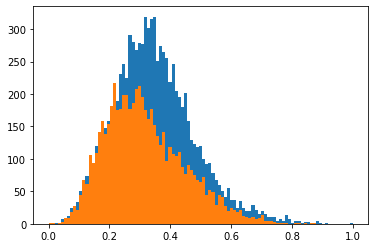

In [39]:
plt.hist(normal, bins=np.linspace(0.0, 1.0, num=100))
plt.hist(anormaly, bins=np.linspace(0.0, 1.0, num=100))
plt.show()

0.3475933920211997 0.3165175918105142
0.13183036051482339 0.1303499470535049


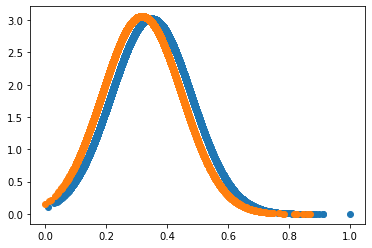

In [40]:
plt.plot(normal, norm.pdf(normal, np.mean(normal), np.std(normal)), 'o')
plt.plot(anormaly, norm.pdf(anormaly, np.mean(anormaly), np.std(anormaly)), 'o')

print(np.mean(normal), np.mean(anormaly))
print(np.std(normal), np.std(anormaly))

In [48]:
zero_zero = 0
zero_one  = 0
one_zero  = 0
one_one   = 0

In [49]:
detection_matrix=[[zero_zero,zero_one],[one_one,one_zero]]

In [50]:
detection_matrix

[[0, 0], [0, 0]]

In [51]:
for i in range(15000):
    if int(bol_test_labels[i]) == 0 and gt_labels[i] == 0:
        zero_zero += 1
    elif int(bol_test_labels[i]) == 0 and gt_labels[i] == 1:
        zero_one += 1
    elif int(bol_test_labels[i]) == 1 and gt_labels[i] == 1:
        one_one += 1
    else: 
        one_zero += 1

In [54]:
detection_matrix=[[zero_zero,zero_one],[one_one,one_zero]]

In [55]:
detection_matrix

[[2618, 3382], [5618, 3382]]

In [56]:
accuracy = (detection_matrix[0][0]+detection_matrix[1][0])*100/15000

In [57]:
print('accuracy:',accuracy)

accuracy: 54.906666666666666


# 결과 및 총평

Skip-GANomaly모델을 사용하여 개구리 감지 모델을 만들어 보았습니다. 한시간 정도를 학습시켰더니 55% 정도의 정확도 밖에 얻지 못하였지만, GAN모델을 시간을 투자하는 만큼 성능을 얻어 내기에 시간을 더 투자한다면 더 좋은 성능을 얻어낼수 있을 것으로 보여집니다.